In [1]:
import numpy as np
import matplotlib.pyplot as plt

from snowScatt.fallSpeed import KhvorostyanovCurry2005 as KC05
from snowScatt import refractiveIndex as ref

from readARMdb import openScatteringRed
from radar import ZeARM
from radar import kdpARM
from PSDqN import PSDGamma3
from PSDqN import _loglog_interp

from readARMdb import InterpScattering
from readARMdb import wlDict

#####################################################################################
# Prep work                      ####################################################
#####################################################################################

wlX = wlDict['X']
K2X = ref.utilities.K2(ref.water.eps(273.15, 299792458000./wlX))
coeffZX = wlX**4 / (np.pi**5 * K2X)

wlKa = wlDict['Ka']
K2Ka = ref.utilities.K2(ref.water.eps(273.15, 299792458000./wlKa))
coeffZKa = wlKa**4 / (np.pi**5 * K2Ka)

wlW = wlDict['W']
K2W = ref.utilities.K2(ref.water.eps(273.15, 299792458000./wlW))
coeffZW = wlW**4 / (np.pi**5 * K2W)

coeffPX = 1e-3 * (180.0/np.pi) * wlX
coeffPKa = 1e-3 * (180.0/np.pi) * wlKa
coeffPW = 1e-3 * (180.0/np.pi) * wlW


def dB(x):
    return 10.0*np.log10(x)

#####################################################################################
# Load scattering tables         ####################################################
#####################################################################################

subtype_agg = 'HD-P1d'
thick_ratio_den = 1.0
slanted_elev = 30

# 3-freq vertically pointing
aggX = openScatteringRed('aggregates', subtype=subtype_agg, band='X', elevation=90)
aggKa = openScatteringRed('aggregates', subtype=subtype_agg, band='Ka', elevation=90)
aggW = openScatteringRed('aggregates', subtype=subtype_agg, band='W', elevation=90)

denX = openScatteringRed('dendrites', thick_ratio=thick_ratio_den, band='X', elevation=90)
denKa = openScatteringRed('dendrites', thick_ratio=thick_ratio_den, band='Ka', elevation=90)
denW = openScatteringRed('dendrites', thick_ratio=thick_ratio_den, band='W', elevation=90)
#plates = openScatteringRed('plates', thick_ratio=1.0)

# polarimetric 3f 30deg elevation
agg_polX = openScatteringRed('aggregates', subtype='HD-P1d', band='X', elevation=slanted_elev)
den_polX = openScatteringRed('dendrites', thick_ratio=1.0, band='X', elevation=slanted_elev)
agg_polKa = openScatteringRed('aggregates', subtype='HD-P1d', band='Ka', elevation=slanted_elev)
den_polKa = openScatteringRed('dendrites', thick_ratio=1.0, band='Ka', elevation=slanted_elev)
agg_polW = openScatteringRed('aggregates', subtype='HD-P1d', band='W', elevation=slanted_elev)
den_polW = openScatteringRed('dendrites', thick_ratio=1.0, band='W', elevation=slanted_elev)

#####################################################################################
# Derive interpolating functions ####################################################
#####################################################################################

aggPXFunc = InterpScattering(agg_polX)
denPXFunc = InterpScattering(den_polX)

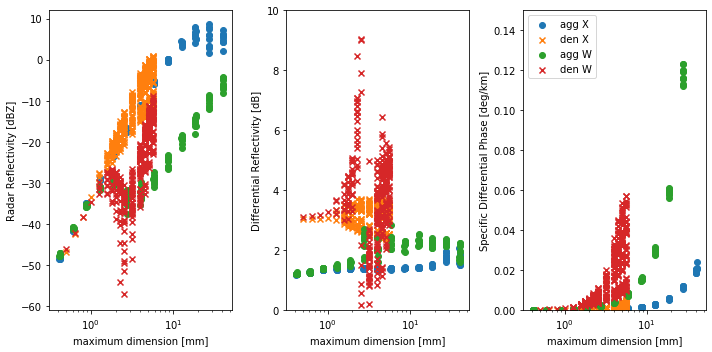

In [2]:
# What I know
"""
sigma_backward_hh == tmatrix.radar.radar_xsect from tmatrix   [mm2] which is 2*pi* Zhh
to get reflectivity Zhh = wl**4 * pi**-5 K2**-1 * int(sigma_hh) 


"""


###    Ze = 
# Let's check if the interpolators work ok

#d = np.logspace(np.log10(0.4), np.log10(45), 1000)
#dd = np.logspace(np.log10(0.4), np.log10(8), 1000)
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
axs[0].scatter(agg_polX.maximum_dimension, dB(coeffZX*agg_polX.sigma_backward_hh))
axs[0].scatter(den_polX.maximum_dimension, dB(coeffZX*den_polX.sigma_backward_hh), marker='x')
#axs[0].scatter(agg_polKa.maximum_dimension, dB(coeffZKa*agg_polKa.sigma_backward_hh))
#axs[0].scatter(den_polKa.maximum_dimension, dB(coeffZKa*den_polKa.sigma_backward_hh), marker='x')
axs[0].scatter(agg_polW.maximum_dimension, dB(coeffZW*agg_polW.sigma_backward_hh))
axs[0].scatter(den_polW.maximum_dimension, dB(coeffZW*den_polW.sigma_backward_hh), marker='x')

#axs[0, 0].scatter(den_pol.maximum_dimension, den_pol.sigma_backward_hh)
#axs[0, 0].plot(d, aggPFunc('sigma_backward_hh', d))
#axs[0, 0].plot(dd, denPFunc('sigma_backward_hh', dd))

axs[1].scatter(agg_polX.maximum_dimension, agg_polX.sigma_backward_hh/agg_polX.sigma_backward_vv)
axs[1].scatter(den_polX.maximum_dimension, den_polX.sigma_backward_hh/den_polX.sigma_backward_vv, marker='x')
#axs[1].scatter(agg_polKa.maximum_dimension, agg_polKa.sigma_backward_hh/agg_polKa.sigma_backward_vv)
#axs[1].scatter(den_polKa.maximum_dimension, den_polKa.sigma_backward_hh/den_polKa.sigma_backward_vv, marker='x')
axs[1].scatter(agg_polW.maximum_dimension, agg_polW.sigma_backward_hh/agg_polW.sigma_backward_vv)
axs[1].scatter(den_polW.maximum_dimension, den_polW.sigma_backward_hh/den_polW.sigma_backward_vv, marker='x')
axs[1].set_ylim(0, 10)


#axs[1, 0].scatter(agg_pol.maximum_dimension, agg_pol.Shh_forward_real)
#axs[1, 0].scatter(den_pol.maximum_dimension, den_pol.Shh_forward_real)
#axs[1, 0].plot(d, aggPFunc('Shh_forward_real', d))
#axs[1, 0].plot(dd, denPFunc('Shh_forward_real', dd))


axs[2].scatter(agg_polX.maximum_dimension, coeffPX*(agg_polX.Shh_forward_real-agg_polX.Svv_forward_real), label='agg X')
axs[2].scatter(den_polX.maximum_dimension, coeffPX*(den_polX.Shh_forward_real-den_polX.Svv_forward_real), marker='x', label='den X')
#axs[2].scatter(agg_polX.maximum_dimension, coeffPKa*(agg_polKa.Shh_forward_real-agg_polKa.Svv_forward_real), label='agg Ka')
#axs[2].scatter(den_polX.maximum_dimension, coeffPKa*(den_polKa.Shh_forward_real-den_polKa.Svv_forward_real), marker='x', label='den Ka')
axs[2].scatter(agg_polX.maximum_dimension, coeffPW*(agg_polW.Shh_forward_real-agg_polW.Svv_forward_real), label='agg W')
axs[2].scatter(den_polX.maximum_dimension, coeffPW*(den_polW.Shh_forward_real-den_polW.Svv_forward_real), marker='x', label='den W')
#axs[2].plot(d, aggPFunc('Shh_forward_real', d)-aggPFunc('Svv_forward_real', d))
#axs[2].plot(dd, denPFunc('Shh_forward_real', dd)-denPFunc('Svv_forward_real', dd))

axs[2].legend()
axs[2].set_ylim(0, 0.15)

axs[0].set_ylabel('Radar Reflectivity [dBZ]')
axs[1].set_ylabel('Differential Reflectivity [dB]')
axs[2].set_ylabel('Specific Differential Phase [deg/km]')

for ax in axs.flatten():
#axs[0, 0].set_xscale('log')
    #ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlabel('maximum dimension [mm]')
fig.tight_layout()
fig.savefig('ARM_polarimetry_mess.png', dpi=150)

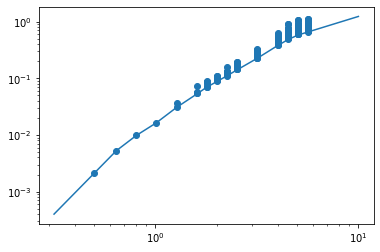

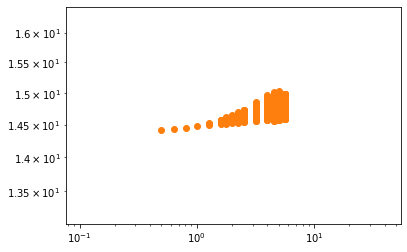

In [4]:
fig, axs = plt.subplots(1,1)
den = den_polX.where(den_polX.mass >= denPXFunc('mass', den_polX.maximum_dimension))
axs.scatter(den.maximum_dimension, den.mass)
D = np.logspace(-0.5, 1, 100)
axs.plot(D, denPXFunc('mass', D))
axs.set_xscale('log')
axs.set_yscale('log')

fig, axs = plt.subplots(1,1)
axs.scatter(agg_polX.maximum_dimension, (agg_polX.Shh_forward_real-agg_polKa.Svv_forward_real)/(agg_polX.Shh_forward_real-agg_polX.Svv_forward_real))
#axs.scatter(agg_polX.maximum_dimension, (agg_polW.Shh_forward_real-agg_polW.Svv_forward_real)/(agg_polKa.Shh_forward_real-agg_polKa.Svv_forward_real))
axs.scatter(den_polX.maximum_dimension, (den_polKa.Shh_forward_real-den_polKa.Svv_forward_real)/(den_polX.Shh_forward_real-den_polX.Svv_forward_real))
#axs.scatter(den_polX.maximum_dimension, (den_polW.SXhh_forward_real-den_polW.Svv_forward_real)/(den_polKa.Shh_forward_real-den_polKa.Svv_forward_real))
D = np.logspace(-0.5, 1, 100)
axs.set_xscale('log')
axs.set_yscale('log')

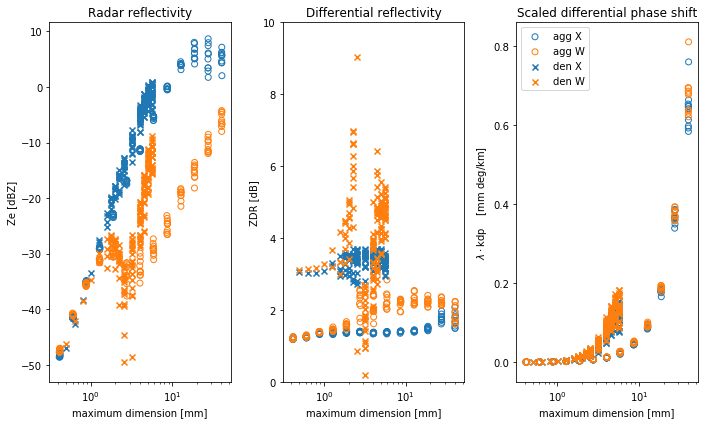

In [42]:
denX = den_polX.where(den_polX.mass >= denPXFunc('mass', den_polX.maximum_dimension))
denKa = den_polKa.where(den_polKa.mass >= denPXFunc('mass', den_polKa.maximum_dimension))
denW = den_polW.where(den_polW.mass >= denPXFunc('mass', den_polW.maximum_dimension))

fig, axs = plt.subplots(1, 3, figsize=(10, 6))
axs[0].scatter(agg_polX.maximum_dimension, dB(coeffZX*agg_polX.sigma_backward_hh), edgecolors='C0', facecolors='none')
#axs[0].scatter(denKa.maximum_dimension, dB(coeffZKa*denKa.sigma_backward_hh), marker='x')
axs[0].scatter(agg_polW.maximum_dimension, dB(coeffZW*agg_polW.sigma_backward_hh), edgecolors='C1', facecolors='none')
axs[0].set_prop_cycle(None)
axs[0].scatter(denX.maximum_dimension, dB(coeffZX*denX.sigma_backward_hh), marker='x')
#axs[0].scatter(agg_polKa.maximum_dimension, dB(coeffZKa*agg_polKa.sigma_backward_hh))
axs[0].scatter(denW.maximum_dimension, dB(coeffZW*denW.sigma_backward_hh), marker='x')

#axs[0, 0].scatter(den_pol.maximum_dimension, den_pol.sigma_backward_hh)
#axs[0, 0].plot(d, aggPFunc('sigma_backward_hh', d))
#axs[0, 0].plot(dd, denPFunc('sigma_backward_hh', dd))

axs[1].scatter(agg_polX.maximum_dimension, agg_polX.sigma_backward_hh/agg_polX.sigma_backward_vv, edgecolors='C0', facecolors='none')
#axs[1].scatter(denKa.maximum_dimension, denKa.sigma_backward_hh/denKa.sigma_backward_vv, marker='x')
axs[1].scatter(agg_polW.maximum_dimension, agg_polW.sigma_backward_hh/agg_polW.sigma_backward_vv, edgecolors='C1', facecolors='none')
axs[1].set_prop_cycle(None)
axs[1].scatter(denX.maximum_dimension, denX.sigma_backward_hh/denX.sigma_backward_vv, marker='x')
#axs[1].scatter(agg_polKa.maximum_dimension, agg_polKa.sigma_backward_hh/agg_polKa.sigma_backward_vv)
axs[1].scatter(denW.maximum_dimension, denW.sigma_backward_hh/denW.sigma_backward_vv, marker='x')
axs[1].set_ylim(0, 10)

axs[2].scatter(agg_polX.maximum_dimension, wlX*coeffPX*(agg_polX.Shh_forward_real-agg_polX.Svv_forward_real), label='agg X', edgecolors='C0', facecolors='none')
#axs[2].scatter(agg_polX.maximum_dimension, coeffPKa*(agg_polKa.Shh_forward_real-agg_polKa.Svv_forward_real), label='agg Ka')
axs[2].scatter(agg_polX.maximum_dimension, wlW*coeffPW*(agg_polW.Shh_forward_real-agg_polW.Svv_forward_real), label='agg W', edgecolors='C1', facecolors='none')
axs[2].set_prop_cycle(None)
axs[2].scatter(denX.maximum_dimension, wlX*coeffPX*(denX.Shh_forward_real-denX.Svv_forward_real), marker='x', label='den X')
#axs[2].scatter(denX.maximum_dimension, coeffPKa*(denKa.Shh_forward_real-denKa.Svv_forward_real), marker='x', label='den Ka')
axs[2].scatter(denX.maximum_dimension, wlW*coeffPW*(denW.Shh_forward_real-denW.Svv_forward_real), marker='x', label='den W')
#axs[2].plot(d, aggPFunc('Shh_forward_real', d)-aggPFunc('Svv_forward_real', d))
#axs[2].plot(dd, denPFunc('Shh_forward_real', dd)-denPFunc('Svv_forward_real', dd))

axs[2].legend()
#axs[2].set_ylim(0, 0.15)

axs[0].set_ylabel('Ze [dBZ]')
axs[0].set_title('Radar reflectivity')
axs[1].set_ylabel('ZDR [dB]')
axs[1].set_title('Differential reflectivity')
axs[2].set_ylabel('$\lambda \cdot$kdp    [mm deg/km]')
axs[2].set_title('Scaled differential phase shift')

for ax in axs.flatten():
#axs[0, 0].set_xscale('log')
    #ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlabel('maximum dimension [mm]')
fig.tight_layout()
fig.savefig('ARM_polarimetry_massive_dendrites.png', dpi=150)

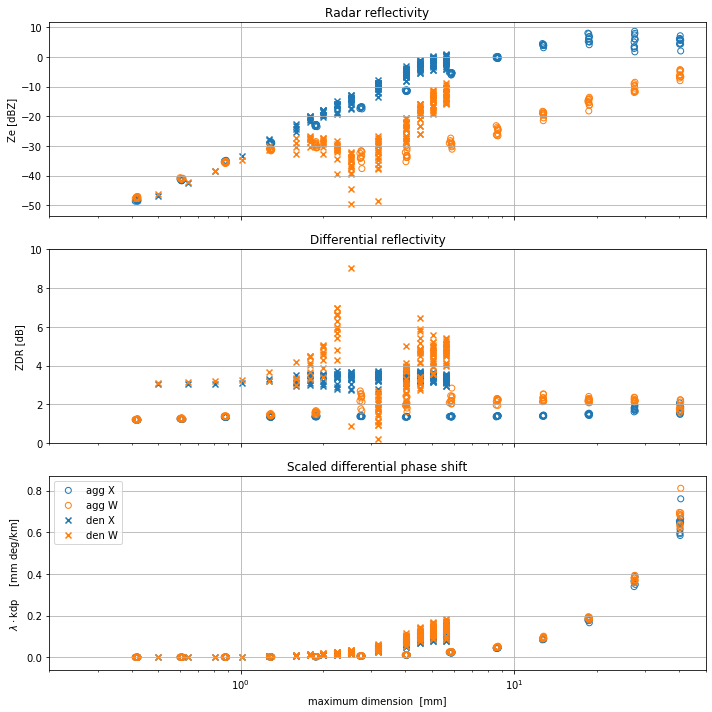

In [41]:
fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
axs[0].scatter(agg_polX.maximum_dimension, dB(coeffZX*agg_polX.sigma_backward_hh), edgecolors='C0', facecolors='none')
#axs[0].scatter(denKa.maximum_dimension, dB(coeffZKa*denKa.sigma_backward_hh), marker='x')
axs[0].scatter(agg_polW.maximum_dimension, dB(coeffZW*agg_polW.sigma_backward_hh), edgecolors='C1', facecolors='none')
axs[0].set_prop_cycle(None)
axs[0].scatter(denX.maximum_dimension, dB(coeffZX*denX.sigma_backward_hh), marker='x')
#axs[0].scatter(agg_polKa.maximum_dimension, dB(coeffZKa*agg_polKa.sigma_backward_hh))
axs[0].scatter(denW.maximum_dimension, dB(coeffZW*denW.sigma_backward_hh), marker='x')

#axs[0, 0].scatter(den_pol.maximum_dimension, den_pol.sigma_backward_hh)
#axs[0, 0].plot(d, aggPFunc('sigma_backward_hh', d))
#axs[0, 0].plot(dd, denPFunc('sigma_backward_hh', dd))

axs[1].scatter(agg_polX.maximum_dimension, agg_polX.sigma_backward_hh/agg_polX.sigma_backward_vv, edgecolors='C0', facecolors='none')
#axs[1].scatter(denKa.maximum_dimension, denKa.sigma_backward_hh/denKa.sigma_backward_vv, marker='x')
axs[1].scatter(agg_polW.maximum_dimension, agg_polW.sigma_backward_hh/agg_polW.sigma_backward_vv, edgecolors='C1', facecolors='none')
axs[1].set_prop_cycle(None)
axs[1].scatter(denX.maximum_dimension, denX.sigma_backward_hh/denX.sigma_backward_vv, marker='x')
#axs[1].scatter(agg_polKa.maximum_dimension, agg_polKa.sigma_backward_hh/agg_polKa.sigma_backward_vv)
axs[1].scatter(denW.maximum_dimension, denW.sigma_backward_hh/denW.sigma_backward_vv, marker='x')
axs[1].set_ylim(0, 10)

axs[2].scatter(agg_polX.maximum_dimension, wlX*coeffPX*(agg_polX.Shh_forward_real-agg_polX.Svv_forward_real), label='agg X', edgecolors='C0', facecolors='none')
#axs[2].scatter(agg_polX.maximum_dimension, coeffPKa*(agg_polKa.Shh_forward_real-agg_polKa.Svv_forward_real), label='agg Ka')
axs[2].scatter(agg_polX.maximum_dimension, wlW*coeffPW*(agg_polW.Shh_forward_real-agg_polW.Svv_forward_real), label='agg W', edgecolors='C1', facecolors='none')
axs[2].set_prop_cycle(None)
axs[2].scatter(denX.maximum_dimension, wlX*coeffPX*(denX.Shh_forward_real-denX.Svv_forward_real), marker='x', label='den X')
#axs[2].scatter(denX.maximum_dimension, coeffPKa*(denKa.Shh_forward_real-denKa.Svv_forward_real), marker='x', label='den Ka')
axs[2].scatter(denX.maximum_dimension, wlW*coeffPW*(denW.Shh_forward_real-denW.Svv_forward_real), marker='x', label='den W')
#axs[2].plot(d, aggPFunc('Shh_forward_real', d)-aggPFunc('Svv_forward_real', d))
#axs[2].plot(dd, denPFunc('Shh_forward_real', dd)-denPFunc('Svv_forward_real', dd))

axs[2].legend()
#axs[2].set_ylim(0, 0.15)

axs[0].set_ylabel('Ze [dBZ]')
axs[0].set_title('Radar reflectivity')
axs[1].set_ylabel('ZDR [dB]')
axs[1].set_title('Differential reflectivity')
axs[2].set_ylabel('$\lambda \cdot$kdp    [mm deg/km]')
axs[2].set_title('Scaled differential phase shift')

for ax in axs.flatten():
    ax.set_xscale('log')
    ax.grid()
    ax.set_xlim(0.2, 50)
axs[2].set_xlabel('maximum dimension  [mm]')
fig.tight_layout()
fig.savefig('ARM_polarimetry_column_grid.png', dpi=150)

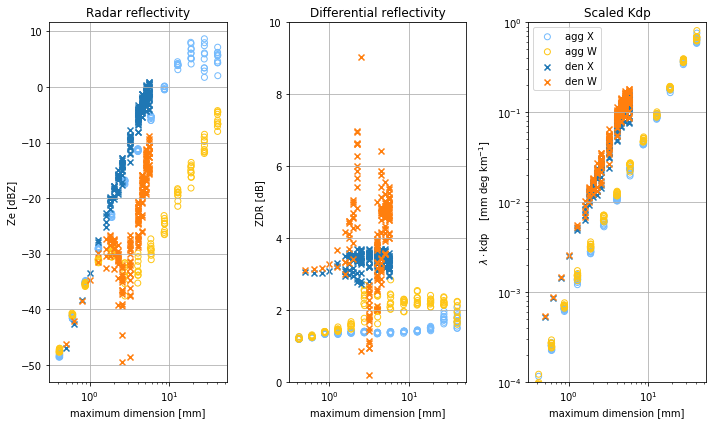

In [66]:
fig, axs = plt.subplots(1, 3, figsize=(10, 6))
axs[0].scatter(agg_polX.maximum_dimension, dB(coeffZX*agg_polX.sigma_backward_hh), edgecolors='#75bbfd', facecolors='none')
axs[0].scatter(agg_polW.maximum_dimension, dB(coeffZW*agg_polW.sigma_backward_hh), edgecolors='#fec615', facecolors='none')
axs[0].set_prop_cycle(None)
axs[0].scatter(denX.maximum_dimension, dB(coeffZX*denX.sigma_backward_hh), marker='x')
axs[0].scatter(denW.maximum_dimension, dB(coeffZW*denW.sigma_backward_hh), marker='x')

axs[1].scatter(agg_polX.maximum_dimension, agg_polX.sigma_backward_hh/agg_polX.sigma_backward_vv, edgecolors='#75bbfd', facecolors='none')
axs[1].scatter(agg_polW.maximum_dimension, agg_polW.sigma_backward_hh/agg_polW.sigma_backward_vv, edgecolors='#fec615', facecolors='none')
axs[1].set_prop_cycle(None)
axs[1].scatter(denX.maximum_dimension, denX.sigma_backward_hh/denX.sigma_backward_vv, marker='x')
axs[1].scatter(denW.maximum_dimension, denW.sigma_backward_hh/denW.sigma_backward_vv, marker='x')
axs[1].set_ylim(0, 10)

axs[2].scatter(agg_polX.maximum_dimension, wlX*coeffPX*(agg_polX.Shh_forward_real-agg_polX.Svv_forward_real), label='agg X', edgecolors='#75bbfd', facecolors='none')
axs[2].scatter(agg_polX.maximum_dimension, wlW*coeffPW*(agg_polW.Shh_forward_real-agg_polW.Svv_forward_real), label='agg W', edgecolors='#fec615', facecolors='none')
axs[2].set_prop_cycle(None)
axs[2].scatter(denX.maximum_dimension, wlX*coeffPX*(denX.Shh_forward_real-denX.Svv_forward_real), marker='x', label='den X')
axs[2].scatter(denX.maximum_dimension, wlW*coeffPW*(denW.Shh_forward_real-denW.Svv_forward_real), marker='x', label='den W')


axs[2].legend()
#axs[2].set_ylim(0, 0.15)

axs[0].set_ylabel('Ze [dBZ]')
axs[0].set_title('Radar reflectivity')
axs[1].set_ylabel('ZDR [dB]')
axs[1].set_title('Differential reflectivity')
axs[2].set_ylabel('$\lambda \cdot$kdp    [mm deg km$^{-1}$]')
axs[2].set_title('Scaled Kdp')
axs[2].set_yscale('log')
axs[2].set_ylim(1e-4, 1.0)

for ax in axs.flatten():
#axs[0, 0].set_xscale('log')
    #ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlabel('maximum dimension [mm]')
    ax.grid()

fig.tight_layout()
fig.savefig('ARM_polarimetry_colorcouples.png', dpi=150)